# Requirements

In [34]:
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from xgboost import XGBRegressor

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [2]:
df = pd.read_csv('data/climate-data.csv')

In [3]:
df.shape

(1462, 5)

In [4]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Explore the dataset using visualizations of your choice.

In [7]:
df["date"] = pd.to_datetime(df["date"])
df.set_index(keys=["date"], inplace=True)
df.sort_index(inplace=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


<Axes: >

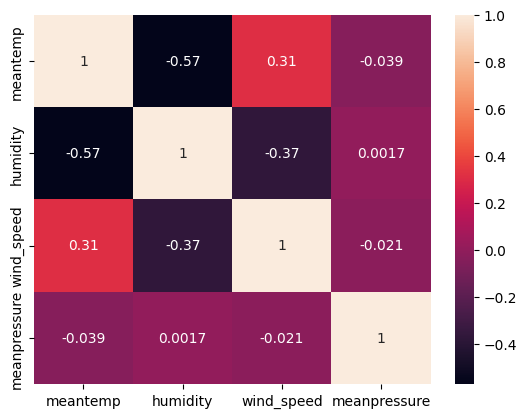

In [8]:
sns.heatmap(df.corr(), annot=True)

<Axes: xlabel='date', ylabel='meantemp'>

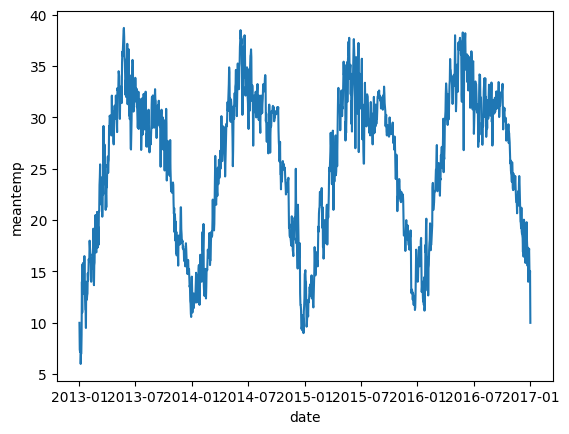

In [11]:
sns.lineplot(df["meantemp"])

<Axes: xlabel='date', ylabel='humidity'>

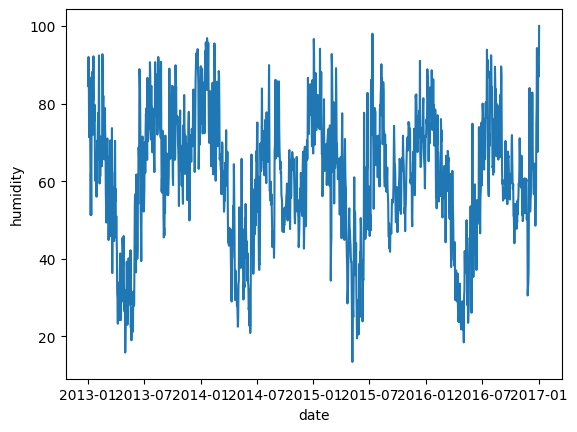

In [12]:
sns.lineplot(df["humidity"])

<Axes: xlabel='date', ylabel='wind_speed'>

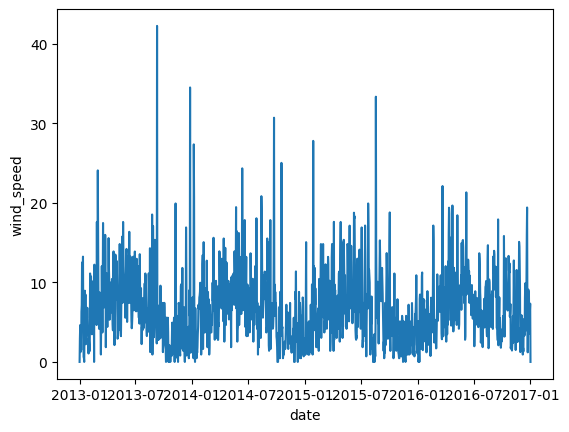

In [13]:
sns.lineplot(df["wind_speed"])

<Axes: xlabel='date', ylabel='meanpressure'>

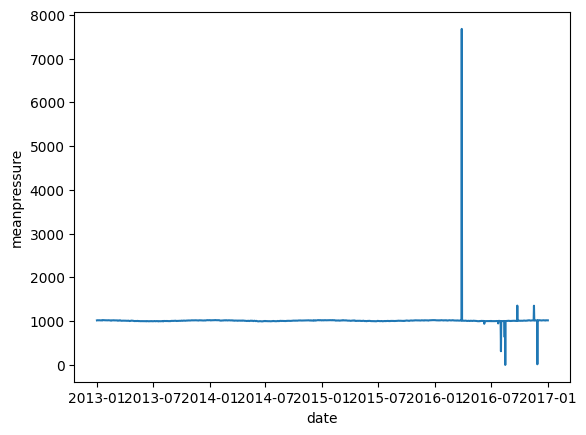

In [14]:
sns.lineplot(df["meanpressure"])

# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [9]:
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [10]:
features = ["humidity", "wind_speed", "meanpressure"]
target = "meantemp"

In [15]:
lags = range(3, 0, -1)
list(lags)

[3, 2, 1]

In [17]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df.head()

,meantemp,humidity,wind_speed,meanpressure,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
date,,,,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.500000,0.000000,1015.666667,10.000000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,NaN,NaN,NaN,NaN,84.5,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000
2013-01-04,8.666667,71.333333,1.233333,1017.166667,84.5,0.00,1015.666667,10.0,92.0,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,92.0,2.98,1017.800000,7.4,87.0,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667


In [18]:
df.drop(columns=features, inplace=True)
df.dropna(axis=0, inplace=True)
df.head()

,meantemp,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
date,,,,,,,,,,,,,
2013-01-04,8.666667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
2013-01-06,7.000000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000
2013-01-07,7.000000,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000
2013-01-08,8.857143,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000,7.000000


In [39]:
df.shape

(1459, 13)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [19]:
X, y = df.drop(columns=[target]), df[target]

In [20]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [24]:
forest = RandomForestRegressor()

In [25]:
forest.fit(train_X, train_y)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [26]:
y_pred = forest.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [27]:
r2_score(test_y, y_pred)

0.8997944571092408

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [28]:
xgb = XGBRegressor()

In [29]:
xgb.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [30]:
y_pred = xgb.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [31]:
r2_score(test_y, y_pred)

0.8734982047911916

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [32]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, shuffle=False)

## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [35]:
time_series_split = TimeSeriesSplit(5)
time_series_split.get_n_splits(X, y)

5

In [36]:
model = XGBRegressor()

In [37]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [40]:
param_grid = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 500],
    'n_jobs': [7]
}

In [41]:
cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=time_series_split)

In [42]:
cv.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 500], 'n_jobs': [7]})

In [43]:
cv.best_score_

0.9304440505769204

In [44]:
model = cv.best_estimator_

In [46]:
y_pred = model.predict(test_X)

## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [47]:
r2_score(test_y, y_pred)

0.9607563405554163